# Race

In [148]:
# General imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Data processing
from sklearn.model_selection import train_test_split

# Models
# LightGBM is a gradient boosting framework that uses tree based learning algorithms
import lightgbm as lgb
from sklearn.calibration import CalibratedClassifierCV

# Fairlearn algorithms and utils
from fairlearn.postprocessing import ThresholdOptimizer
from fairlearn.reductions import GridSearch, EqualizedOdds

# Metrics
from fairlearn.metrics import (
    MetricFrame,
    selection_rate, demographic_parity_difference, demographic_parity_ratio,
    true_positive_rate, false_positive_rate, false_negative_rate,
    false_positive_rate_difference, false_negative_rate_difference,
    equalized_odds_difference)
from sklearn.metrics import balanced_accuracy_score, roc_auc_score

In [149]:
# load the clean data
dc = 'data/Fairlearn_DC.csv'
dc = pd.read_csv(dc, sep = ',')
dc.head()

,ethnicity,race,gender,action_taken,preapproval_requested,loan_type,loan_purpose,interest_only_payment,balloon_payment,debt_to_income_ratio,age,income,loan_to_value_ratio
0,0,1,0,1,0,1,1,2,2,3,3,1,1
1,0,1,1,1,0,3,3,2,2,4,3,3,1
2,0,2,0,1,0,1,3,2,2,4,2,3,3
3,0,1,0,1,0,1,3,2,2,2,3,5,1
4,0,3,0,1,0,1,1,2,2,4,3,2,1


In [150]:
# load the clean data
fl = 'data/Fairlearn_FL_PortSL.csv'
fl = pd.read_csv(fl, sep = ',')
fl.head()

,ethnicity,race,gender,action_taken,preapproval_requested,loan_type,loan_purpose,interest_only_payment,balloon_payment,debt_to_income_ratio,age,income,loan_to_value_ratio
0,0,1,1,1,0,1,1,2,2,3,3,1,1
1,0,1,1,1,0,1,1,2,2,4,2,2,3
2,0,1,0,1,0,1,1,2,2,4,2,3,1
3,0,1,0,1,0,1,3,2,2,2,2,3,1
4,0,1,0,1,0,1,1,2,2,2,3,2,1


In [151]:
# load the clean data
tx = 'data/Fairlearn_TX_Waco.csv'
tx = pd.read_csv(tx, sep = ',')
tx.head()

,ethnicity,race,gender,action_taken,preapproval_requested,loan_type,loan_purpose,interest_only_payment,balloon_payment,debt_to_income_ratio,age,income,loan_to_value_ratio
0,0,1,1,1,0,1,1,2,2,4,1,2,3
1,0,1,1,0,0,1,3,2,2,4,2,2,1
2,1,1,1,1,0,1,1,2,2,4,2,3,1
3,0,1,1,1,0,1,1,2,2,1,3,3,3
4,1,1,0,1,0,1,1,2,2,4,2,4,1


In [152]:
# load the clean data
il = 'data/Fairlearn_IL_Chicago.csv'
il = pd.read_csv(il, sep = ',')
il.head()

,ethnicity,race,gender,action_taken,preapproval_requested,loan_type,loan_purpose,interest_only_payment,balloon_payment,debt_to_income_ratio,age,income,loan_to_value_ratio
0,0,1,0,1,0,1,3,2,2,3,2,2,1
1,0,1,1,0,0,1,2,2,2,4,3,4,1
2,0,1,1,1,0,1,1,2,2,3,2,1,1
3,0,1,0,1,0,1,3,2,2,2,2,2,1
4,1,1,1,1,0,1,3,2,2,4,2,3,1


In [153]:
# training set = FL + TX + IL, testing set = DC
all_df = pd.concat([tx, fl, il, dc])

In [154]:
all_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 212714 entries, 0 to 89154
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype
---  ------                 --------------   -----
 0   ethnicity              212714 non-null  int64
 1   race                   212714 non-null  int64
 2   gender                 212714 non-null  int64
 3   action_taken           212714 non-null  int64
 4   preapproval_requested  212714 non-null  int64
 5   loan_type              212714 non-null  int64
 6   loan_purpose           212714 non-null  int64
 7   interest_only_payment  212714 non-null  int64
 8   balloon_payment        212714 non-null  int64
 9   debt_to_income_ratio   212714 non-null  int64
 10  age                    212714 non-null  int64
 11  income                 212714 non-null  int64
 12  loan_to_value_ratio    212714 non-null  int64
dtypes: int64(13)
memory usage: 22.7 MB


In [155]:
# Extract the sensitive feature - example: race
A = all_df["race"].apply(lambda x:1 if x == 1 else 0)
A_str = A.map({ 1:"White", 0:"Non-White"})
A_str

0            White
1            White
2            White
3            White
4            White
           ...    
89150    Non-White
89151        White
89152        White
89153    Non-White
89154        White
Name: race, Length: 212714, dtype: object

In [156]:
# Extract the target
Y = all_df["action_taken"]
categorical_features = ['preapproval_requested', 'loan_type','loan_purpose', 'interest_only_payment', 'balloon_payment', 'debt_to_income_ratio', 'income']
for col in categorical_features:
    all_df[col] = all_df[col].astype('category')
all_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 212714 entries, 0 to 89154
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype   
---  ------                 --------------   -----   
 0   ethnicity              212714 non-null  int64   
 1   race                   212714 non-null  int64   
 2   gender                 212714 non-null  int64   
 3   action_taken           212714 non-null  int64   
 4   preapproval_requested  212714 non-null  category
 5   loan_type              212714 non-null  category
 6   loan_purpose           212714 non-null  category
 7   interest_only_payment  212714 non-null  category
 8   balloon_payment        212714 non-null  category
 9   debt_to_income_ratio   212714 non-null  category
 10  age                    212714 non-null  int64   
 11  income                 212714 non-null  category
 12  loan_to_value_ratio    212714 non-null  int64   
dtypes: category(7), int64(6)
memory usage: 12.8 MB


In [157]:
# Train-test split
df_train = all_df.drop(columns=['race', 'action_taken', 'ethnicity', 'gender', 'age']).head(89155)
df_test = all_df.drop(columns=['race', 'action_taken', 'ethnicity', 'gender', 'age']).tail(34404)
Y_train = Y.head(89155)
Y_test = Y.tail(34404)
A_train = A.head(89155)
A_test = A.tail(34404)
A_str_train = A_str.head(89155)
A_str_test = A_str.tail(34404)

In [158]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 89155 entries, 0 to 76477
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   preapproval_requested  89155 non-null  category
 1   loan_type              89155 non-null  category
 2   loan_purpose           89155 non-null  category
 3   interest_only_payment  89155 non-null  category
 4   balloon_payment        89155 non-null  category
 5   debt_to_income_ratio   89155 non-null  category
 6   income                 89155 non-null  category
 7   loan_to_value_ratio    89155 non-null  int64   
dtypes: category(7), int64(1)
memory usage: 2.0 MB


In [159]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34404 entries, 54751 to 89154
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   preapproval_requested  34404 non-null  category
 1   loan_type              34404 non-null  category
 2   loan_purpose           34404 non-null  category
 3   interest_only_payment  34404 non-null  category
 4   balloon_payment        34404 non-null  category
 5   debt_to_income_ratio   34404 non-null  category
 6   income                 34404 non-null  category
 7   loan_to_value_ratio    34404 non-null  int64   
dtypes: category(7), int64(1)
memory usage: 773.9 KB


## Using a Fairness Unaware Model

In [160]:
lgb_params = {
    'objective' : 'binary',
    'metric' : 'auc',
    'learning_rate': 0.03,
    'num_leaves' : 10,
    'max_depth' : 3
}

In [161]:
model = lgb.LGBMClassifier(**lgb_params)

In [162]:
model.fit(df_train, Y_train)

LGBMClassifier(learning_rate=0.03, max_depth=3, metric='auc', num_leaves=10,
               objective='binary')

In [163]:
# Scores on test set
test_scores = model.predict_proba(df_test)[:, 1]

In [164]:
# Train AUC
roc_auc_score(Y_train, model.predict_proba(df_train)[:, 1])

0.8407577272580641

In [165]:
# Predictions (0 or 1) on test set
test_preds = (test_scores >= np.mean(Y_train)) * 1

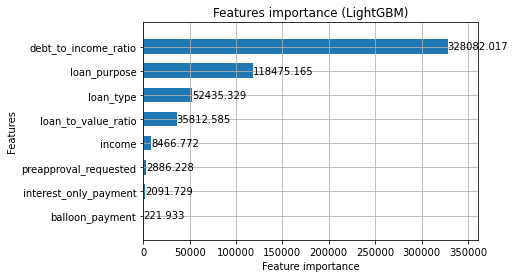

In [166]:
# LightGBM feature importance 
lgb.plot_importance(model, height=0.6, title="Features importance (LightGBM)", importance_type="gain", max_num_features=15) 
plt.show()

We next use Fairlearn's `MetricFrame` to examine the the two different kinds of errors (false positives and false negatives) on the test data.

In [167]:
mf = MetricFrame({
    'FPR': false_positive_rate,
    'FNR': false_negative_rate},
    Y_test, test_preds, sensitive_features=A_str_test)

mf.by_group 

C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\metrics\_metric_frame.py:63: FutureWarning: You have provided 'metrics', 'y_true', 'y_pred' as positional arguments. Please pass them as keyword arguments. From version 0.10.0 passing them as positional arguments will result in an error.
  warnings.warn(f"You have provided {args_msg} as positional arguments. "


,FPR,FNR
race,,
Non-White,0.365352,0.153614
White,0.366203,0.133214


In [169]:
test_preds

array([1, 1, 0, ..., 1, 1, 1])

In [185]:
test_preds_series = pd.Series(test_preds)
test_preds_series.reset_index(drop=True, inplace=True)
A_str_test.reset_index(drop=True, inplace=True)

In [186]:
pred_white = pd.concat([test_preds_series , A_str_test], axis="columns")

In [187]:
pred_white

,0,race
0,1,White
1,1,White
2,0,White
3,0,White
4,1,White
...,...,...
34399,1,Non-White
34400,1,White
34401,1,White
34402,1,Non-White


In [192]:
pred_white.columns =['Unmitigated Result', 'Race']

In [193]:
pred_white.groupby(['Unmitigated Result','Race'])['Race'].count()

Unmitigated Result  Race     
0                   Non-White     4306
                    White         3832
1                   Non-White    10783
                    White        15483
Name: Race, dtype: int64

In [58]:
# Helper functions
def get_metrics_df(models_dict, y_true, group):
    metrics_dict = {
        "Overall selection rate": (
            lambda x: selection_rate(y_true, x), True),
        "Demographic parity difference": (
            lambda x: demographic_parity_difference(y_true, x, sensitive_features=group), True),
        "Demographic parity ratio": (
            lambda x: demographic_parity_ratio(y_true, x, sensitive_features=group), True),
        "------": (lambda x: "", True),
        "Overall balanced error rate": (
            lambda x: balanced_accuracy_score(y_true, x), True),
        "Balanced error rate difference": (
            lambda x: MetricFrame(metrics=balanced_accuracy_score, y_true=y_true, y_pred=x, sensitive_features=group).difference(method='between_groups'), True),
        " ------": (lambda x: "", True),
        # defined by team6 - equal opportunity - the percentage of people that have rightfully benefitted from the loan model
        "True positive rate": (
            lambda x: true_positive_rate(y_true, x), True),
        # defined by team6 - equalized odds - the percentage of people that have wrongfully benefitted from the loan model
        "False positive rate difference": (
            lambda x: false_positive_rate_difference(y_true, x, sensitive_features=group), True),
        "False negative rate difference": (
            lambda x: false_negative_rate_difference(y_true, x, sensitive_features=group), True),
        # defined by UCI Ex - 0 means that all groups have the same true positive, true negative, false positive, and false negative rates.)
        "Equalized odds difference": (
            lambda x: equalized_odds_difference(y_true, x, sensitive_features=group), True),
        "  ------": (lambda x: "", True),
        "Overall AUC": (
            lambda x: roc_auc_score(y_true, x), False),
        "AUC difference": (
            lambda x: MetricFrame(metrics=roc_auc_score, y_true=y_true, y_pred=x, sensitive_features=group).difference(method='between_groups'), False)
        
    }
    df_dict = {}
    for metric_name, (metric_func, use_preds) in metrics_dict.items():
        df_dict[metric_name] = [metric_func(preds) if use_preds else metric_func(scores) 
                                for model_name, (preds, scores) in models_dict.items()]
    return pd.DataFrame.from_dict(df_dict, orient="index", columns=models_dict.keys())

We calculate several performance and fairness metrics below:

In [59]:
# Metrics
models_dict = {"Unmitigated": (test_preds, test_scores)}
get_metrics_df(models_dict, Y_test, A_str_test)

,Unmitigated
Overall selection rate,0.763458
Demographic parity difference,0.009518
Demographic parity ratio,0.987569
------,
Overall balanced error rate,0.74653
Balanced error rate difference,0.008483
------,
True positive rate,0.858733
False positive rate difference,0.003538
False negative rate difference,0.013427


## Mitigating Equalized Odds Difference with Postprocessing

We attempt to mitigate the disparities in the `lightgbm` predictions using the Fairlearn postprocessing algorithm `ThresholdOptimizer`. This algorithm finds a suitable threshold for the scores (class probabilities) produced by the `lightgbm` model by optimizing the accuracy rate under the constraint that the equalized odds difference (on training data) is zero. Since our goal is to optimize balanced accuracy, we resample the training data to have the same number of positive and negative examples. This means that `ThresholdOptimizer` is effectively optimizing balanced accuracy on the original data.

In [195]:
postprocess_est = ThresholdOptimizer(
    estimator=model,
    constraints="equalized_odds",
    prefit=True)

In [196]:
# Balanced data set is obtained by sampling the same number of points from the majority class (Y=0)
# as there are points in the minority class (Y=1)
balanced_idx1 = df_train[Y_train==1].index
pp_train_idx = balanced_idx1.union(Y_train[Y_train==0].sample(n=balanced_idx1.size, random_state=1234, replace=True).index)

In [197]:
df_train_balanced = df_train.loc[pp_train_idx, :]
Y_train_balanced = Y_train.loc[pp_train_idx]
A_train_balanced = A_train.loc[pp_train_idx]

In [198]:
postprocess_est.fit(df_train_balanced, Y_train_balanced, sensitive_features=A_train_balanced)

C:\Users\Xue Feng\anaconda3\lib\site-packages\fairlearn\postprocessing\_threshold_optimizer.py:270: FutureWarning: 'predict_method' default value is changed from 'predict' to 'auto'. Explicitly pass `predict_method='predict' to replicate the old behavior, or pass `predict_method='auto' or other valid values to silence this warning.
  warn(


ThresholdOptimizer(constraints='equalized_odds',
                   estimator=LGBMClassifier(learning_rate=0.03, max_depth=3,
                                            metric='auc', num_leaves=10,
                                            objective='binary'),
                   prefit=True)

In [199]:
postprocess_preds = postprocess_est.predict(df_test, sensitive_features=A_test)

In [200]:
models_dict = {"Unmitigated": (test_preds, test_scores),
              "ThresholdOptimizer": (postprocess_preds, postprocess_preds)}
get_metrics_df(models_dict, Y_test, A_str_test)

,Unmitigated,ThresholdOptimizer
Overall selection rate,0.763458,0.881758
Demographic parity difference,0.086978,0.083795
Demographic parity ratio,0.891495,0.908771
------,,
Overall balanced error rate,0.74653,0.704342
Balanced error rate difference,0.009775,0.008729
------,,
True positive rate,0.858733,0.960729
False positive rate difference,0.000851,0.04004
False negative rate difference,0.0204,0.022582


The `ThresholdOptimizer` algorithm significantly reduces the disparity according to multiple metrics. However, the performance metrics (balanced error rate as well as AUC) get worse. Before deploying such a model in practice, it would be important to examine in more detail why we observe such a sharp trade-off. In our case it is because the available features are much less informative for one of the demographic groups than for the other.

Note that unlike the unmitigated model, `ThresholdOptimizer` produces 0/1 predictions, so its balanced error rate difference is equal to the AUC difference, and its overall balanced error rate is equal to 1 - overall AUC.

## Mitigating Equalized Odds Difference with GridSearch

We now attempt to mitigate disparities using the `GridSearch` algorithm. Unlike `ThresholdOptimizer`, the predictors produced by `GridSearch` do not access the sensitive feature at test time. Also, rather than training a single model, we train multiple models corresponding to different trade-off points between the performance metric (balanced accuracy) and fairness metric (equalized odds difference).

In [ ]:
# Train GridSearch
sweep = GridSearch(model,
                   constraints=EqualizedOdds(),
                   grid_size=1000,
                   grid_limit=10)

sweep.fit(df_train_balanced, Y_train_balanced, sensitive_features=A_train_balanced)

In [202]:
sweep_preds = [predictor.predict(df_test) for predictor in sweep.predictors_] 
sweep_scores = [predictor.predict_proba(df_test)[:, 1] for predictor in sweep.predictors_]

In [203]:
equalized_odds_sweep = [
    equalized_odds_difference(Y_test, preds, sensitive_features=A_str_test)
    for preds in sweep_preds
]
balanced_accuracy_sweep = [balanced_accuracy_score(Y_test, preds) for preds in sweep_preds]
auc_sweep = [roc_auc_score(Y_test, scores) for scores in sweep_scores]

In [204]:
# Select only non-dominated models (with respect to balanced accuracy and equalized odds difference)
all_results = pd.DataFrame(
    {"predictor": sweep.predictors_, "accuracy": balanced_accuracy_sweep, "disparity": equalized_odds_sweep}
) 
non_dominated = [] 
for row in all_results.itertuples(): 
    accuracy_for_lower_or_eq_disparity = all_results["accuracy"][all_results["disparity"] <= row.disparity] 
    if row.accuracy >= accuracy_for_lower_or_eq_disparity.max(): 
        non_dominated.append(True)
    else:
        non_dominated.append(False)

equalized_odds_sweep_non_dominated = np.asarray(equalized_odds_sweep)[non_dominated]
balanced_accuracy_non_dominated = np.asarray(balanced_accuracy_sweep)[non_dominated]
auc_non_dominated = np.asarray(auc_sweep)[non_dominated]

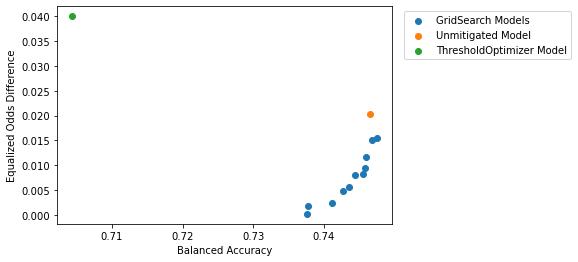

In [205]:
# Plot equalized odds difference vs balanced accuracy
plt.scatter(balanced_accuracy_non_dominated, equalized_odds_sweep_non_dominated, label="GridSearch Models")
plt.scatter(balanced_accuracy_score(Y_test, test_preds),
            equalized_odds_difference(Y_test, test_preds, sensitive_features=A_str_test), 
            label="Unmitigated Model")
plt.scatter(balanced_accuracy_score(Y_test, postprocess_preds), 
            equalized_odds_difference(Y_test, postprocess_preds, sensitive_features=A_str_test),
            label="ThresholdOptimizer Model")
plt.xlabel("Balanced Accuracy")
plt.ylabel("Equalized Odds Difference")
plt.legend(bbox_to_anchor=(1.55, 1))
plt.show()

As intended, `GridSearch` models appear along the trade-off curve between the large balanced accuracy (but also large disparity), and low disparity (but worse balanced accuracy). This gives the data scientist a flexibility to select a model that fits the application context best.

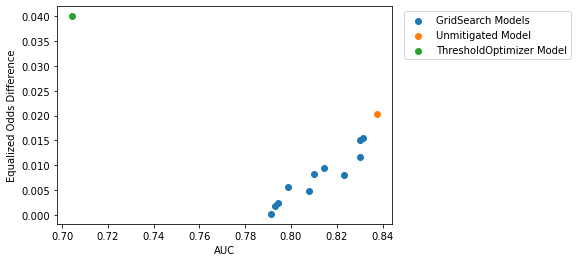

In [206]:
# Plot equalized odds difference vs AUC
plt.scatter(auc_non_dominated, equalized_odds_sweep_non_dominated, label="GridSearch Models")
plt.scatter(roc_auc_score(Y_test, test_scores),
            equalized_odds_difference(Y_test, test_preds, sensitive_features=A_str_test), 
            label="Unmitigated Model")
plt.scatter(roc_auc_score(Y_test, postprocess_preds), 
            equalized_odds_difference(Y_test, postprocess_preds, sensitive_features=A_str_test),
            label="ThresholdOptimizer Model")
plt.xlabel("AUC")
plt.ylabel("Equalized Odds Difference")
plt.legend(bbox_to_anchor=(1.55, 1))
plt.show()

Similarly, `GridSearch` models appear along the trade-off curve between AUC and equalized odds difference.

In [207]:
# Compare GridSearch models with low values of equalized odds difference with the previously constructed models
grid_search_dict = {"GridSearch_{}".format(i): (sweep_preds[i], sweep_scores[i])
                    for i in range(len(sweep_preds))
                    if non_dominated[i] and equalized_odds_sweep[i]<0.1}
models_dict.update(grid_search_dict)
get_metrics_df(models_dict, Y_test, A_str_test)

,Unmitigated,ThresholdOptimizer,GridSearch_464,GridSearch_508,GridSearch_552,GridSearch_707,GridSearch_827,GridSearch_853,GridSearch_883,GridSearch_898,GridSearch_901,GridSearch_966,GridSearch_978
Overall selection rate,0.763458,0.881758,0.770608,0.777381,0.771015,0.785548,0.774532,0.776741,0.769823,0.776857,0.776538,0.752238,0.736659
Demographic parity difference,0.086978,0.083795,0.083778,0.079669,0.082732,0.076392,0.077546,0.076405,0.069749,0.073189,0.072029,0.071008,0.068165
Demographic parity ratio,0.891495,0.908771,0.896231,0.901924,0.89752,0.906731,0.904091,0.905702,0.912858,0.909527,0.910869,0.909358,0.911076
------,,,,,,,,,,,,,
Overall balanced error rate,0.74653,0.704342,0.747512,0.746022,0.746832,0.744465,0.745935,0.745626,0.737796,0.742808,0.743542,0.741161,0.737658
Balanced error rate difference,0.009775,0.008729,0.006364,0.006019,0.007316,0.004552,0.00594,0.005588,0.000946,0.003548,0.004734,0.001574,0.000019
------,,,,,,,,,,,,,
True positive rate,0.858733,0.960729,0.866263,0.87246,0.866407,0.880026,0.869578,0.871667,0.861724,0.870695,0.870659,0.845439,0.828506
False positive rate difference,0.000851,0.04004,0.002771,0.000476,0.000352,0.001026,0.002516,0.003034,0.000077,0.00222,0.005557,0.000792,0.000173
False negative rate difference,0.0204,0.022582,0.015499,0.011562,0.014983,0.008077,0.009364,0.008141,0.001816,0.004875,0.003911,0.002357,0.000135


In [211]:
# chose the model with AUC = 82.32% from grid search
test_pred_gird_search_707 = grid_search_dict.get("GridSearch_707")[0]

In [212]:
test_pred_gird_search_707_series = pd.Series(test_pred_gird_search_707)
test_pred_gird_search_707_series.reset_index(drop=True, inplace=True)

In [213]:
migigated_pred_white = pd.concat([test_pred_gird_search_707_series , A_str_test], axis="columns")

In [214]:
migigated_pred_white

,0,race
0,1,White
1,1,White
2,0,White
3,0,White
4,1,White
...,...,...
34399,1,Non-White
34400,1,White
34401,1,White
34402,1,Non-White


In [217]:
migigated_pred_white.columns =['Mitigated Result', 'Race']

In [218]:
migigated_pred_white.groupby(['Mitigated Result','Race'])['Race'].count()

Mitigated Result  Race     
0                 Non-White     3883
                  White         3495
1                 Non-White    11206
                  White        15820
Name: Race, dtype: int64

## Conclusion

In this notebook, we explored how a fairness-unaware gradient boosted trees model performed on the classification task in contrast to the postprocessed `ThresholdOptimizer` model and the `GridSearch` model. The `ThresholdOptimizer` greatly reduced the disparity in performance across multiple fairness metrics. However the overall error rate and AUC for the `ThresholdOptimizer` model were worse compared to the fairness-unaware model. 

With the `GridSearch` algorithm, we trained multiple models that balance the trade-off between the balanced accuracy and the equalized odds fairness metric. After engaging with relevant stakeholders, the data scientist can deploy the model that balances the performance-fairness trade-off that meets the needs of the business.

# Age